# Parcours de Graphes

Ce document vise à illustrer les algorithmes classiques de parcours de graphes

## Graphe

Un graphe est un objet mathématique constitué de :

* un ensemble $V$ de sommets
* un ensemble $E \subset V \times V$ d'arêtes reliant ces sommets

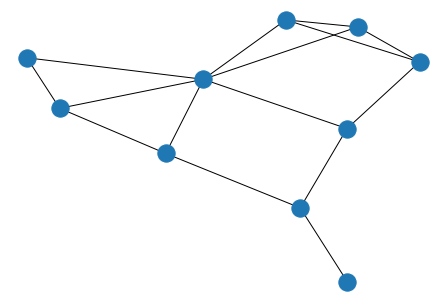

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.gnp_random_graph(10, 0.4)
nx.draw(G)

Ici les sommets sont les points bleus, et les arêtes sont les lignes qui les relient. On distingue les **graphes non orientés**, pour lesquels les arêtes n'ont pas de notion de direction, et les **graphes orientés**, pour lesquels l'arête de u à v n'est pas la même que l'arête de v à u. En terme de terminologie, on utilise souvent le terme *arc* plutôt qu'arête pour le cas non orienté.

Les graphes permettent de modéliser de très nombreux problèmes, et se prêtent également bien à l'étude des structures de données. Une liste chaînée par exemple peut être vue comme un graphe où les sommets sont les cellules et les arêtes sont les liens des cellules vers leurs suivantes. Plus généralement toute structure de donnée ou des petits blocs de mémoire sont liés les uns aux autres par des adresses ou des références se prête bien à ce formalisme.

Le code qui suit vise à générer des graphes et les animer, il n'est pas important pour la compréhension de la suite.

In [2]:
# Cliquer à gauche pour voir ou masquer le code

import matplotlib.animation
from IPython.display import HTML
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import shapely.geometry as geom
import math
import random

def animate_graph(G, positions, animation, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.close()
        
    def update(frame):
        ax.clear()
        
        nx.draw(G, pos=positions, ax=ax, node_size=200, node_color = animation['colors'][frame], width = animation['widths'][frame], **kwargs)
                
    ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(animation['colors']), interval=80, repeat=True)
    return HTML(ani.to_html5_video())

def disk_lloyd(pts):
    new_pts = []
    vor = Voronoi(pts)
    disk = geom.Point(0,0).buffer(1.0)
    for i in range(len(pts)):
        pt = pts[i]
        r = vor.regions[vor.point_region[i]]
        if -1 not in r:
            p = geom.Polygon([vor.vertices[k] for k in r]).intersection(disk)
            new_pts.append(p.centroid.coords[:][0])
        else:
            new_pts.append(pt)
    return new_pts

def gen_in_disk(size):
    #https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly
    pts = []
    for i in range(size):
        t = 2*math.pi*random.random()
        u = random.random()+random.random()
        if u>1:
            r = 2-u 
        else:
            r = u
        pts.append((r*math.cos(t), r*math.sin(t)))
    #smooth
    for i in range(20):
        pts = disk_lloyd(pts)
    return pts
        
def delaunay_graph(pts):
    G = nx.Graph()
    delaunay = Delaunay(pts)
    for s in delaunay.simplices:
        for i in range(3):
            v0 = s[i]
            v1 = s[(i+1)%3]
            G.add_edge(v0,v1)
    for i, n in enumerate(G.nodes):
        G.nodes[n]['index'] = i
    for i,e in enumerate(G.edges):
        G.edges[e]['index'] = i
    return G

def leftmost(g, pts):
    lm = 0
    xlm = pts[lm][0]
    for n in G.nodes:
        xn = pts[n][0]
        if xn < xlm:
            lm = n
            xlm = xn
    return lm

def rightmost(g, pts):
    lm = 0
    xlm = pts[lm][0]
    for n in G.nodes:
        xn = pts[n][0]
        if xn > xlm:
            lm = n
            xlm = xn
    return lm

class animated_container:
    
    def __init__(self, G):
        self.init_color = "gray"
        self.pushed_color = "cornflowerblue"
        self.popped_color = "darkorange"
        self.current_color = "gold"
    
        self.init_width = 1
        self.used_width = 5
        
        self.colors = [self.init_color for n in G.nodes]
        self.widths = [self.init_width for e in G.edges]
        
        self.animation = {'colors':[], 'widths':[]}
        self.pop_steps = []
        self.current = None
        
        self.graph = G
        
    def append_animation(self):
        colors = self.colors[:]
        if self.current != None:
            colors[self.current] = self.current_color
        self.animation['colors'].append(colors)
        self.animation['widths'].append(self.widths[:])
        
    def push(self,v,u = None):
        self.colors[self.graph.nodes[v]['index']] = self.pushed_color
        if u != None:
            self.widths[self.graph[u][v]['index']] = self.used_width
        self.append_animation()
        
    def pop(self,u):
        self.colors[self.graph.nodes[u]['index']] = self.popped_color
        self.append_animation()
        self.pop_steps.append(self.graph.nodes.data())
    
    def top(self,v):
        self.current = self.graph.nodes[v]['index']
    
    def empty(self):
        return 

Nous pouvons maintenant générer aléatoirement des graphes permettant d'illustrer facilement les parcours, car leurs arêtes ne partent pas dans tous les sens.

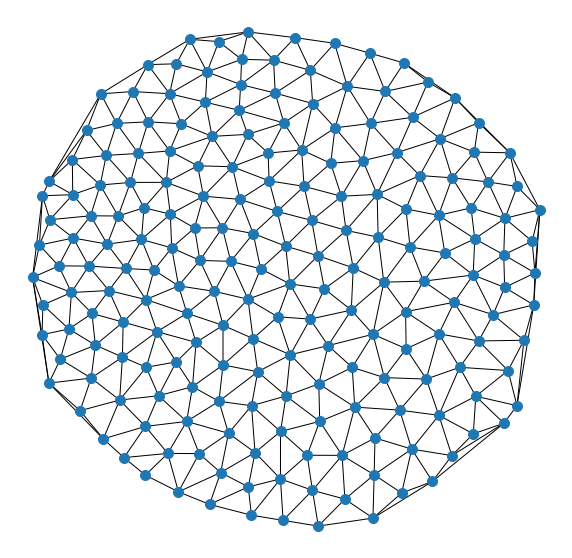

In [3]:
pts = gen_in_disk(200)
G = delaunay_graph(pts)
plt.subplots(figsize=(10,10))
nx.draw(G, pos=pts, node_size = 100)

## Traverser un graphe

Le principe de la traversée d'un graphe consiste à partir d'un sommet et étendre le parcours à ses voisins. Il est donc nécessaire de :

* maintenir un ensemble des sommets à traiter
* pouvoir déterminer si un sommet a déjà été rencontré

Initialement, seul le sommet de départ a été rencontré et a été traité. On distingue :

* le parcours en profondeur qui utilise une **pile** pour l'ensemble des sommets à traiter
* le parcours en largeur qui utilise une **file** pour l'ensemble des sommets à traiter

À part cette différence de gestion des sommets à traiter l'algorithme de parcours est le même. De manière générique nous pouvons le coder comme suit.

In [4]:
# G est le graphe
# start le sommet de départ
# s la structure de données à utiliser pour stocker les sommets à traiter

def traverse(G, start, s):    
    # initialement, aucun sommet n'est traité
    for n in G.nodes:
        G.nodes[n]['visited'] = False
    
    # on ajoute le sommet de départ aux sommets à traiter
    s.push(start)
    # on le marque comme vu
    G.nodes[start]['visited'] = True
    
    #tant qu'il reste des sommets à traiter
    while not s.empty():
        # récupérer un sommet à traiter
        t = s.top()
        # si ce sommet a un voisin non vu
        finished = True
        for n in G.neighbors(t):
            if not G.nodes[n]['visited']:
                # marquer le voisin comme vu
                G.nodes[n]['visited'] = True
                # l'ajouter aux sommets à traiter
                s.push(n, t)
                # indiquer qu'un voisin inconnu a été rencontré
                finished = False
                break
        # lorsqu'aucun voisin n'était inconnu
        if finished:
            # retirer le sommet de l'ensemble des sommets à traiter
            s.pop()

### Parcours en profondeur à l'aide d'une pile

In [5]:
# Implémentation d'une pile

class stack(animated_container):
    
    def __init__(self, G):
        super().__init__(G)
        
        # la pile est implémentée dans un tableau
        self.data = []
        
    def push(self,v,u = None):
        super().push(v, u)
        
        # l'insertion se fait en fin de tableau
        self.data.append(v)
        
    def pop(self):
        u = self.top()
        super().pop(u)
        
        # le retrait se fait en fin de tableau
        self.data.pop()
        
    def top(self):
        # le sommet de la pile est en fin de tableau
        t = self.data[-1]
        super().top(t)
        return t
    
    def empty(self):
        super().empty()
        return len(self.data) == 0

En utilisant une pile, la politique "last in first out" (LIFO) fait que l'algorithme cherche à avancer le plus possible sans attendre d'avoir fini d'étudier intégralement les voisins d'un sommet.

In [6]:
begin = leftmost(G, pts)
s = stack(G)
traverse(G, begin, s)

In [7]:
animate_graph(G, pts, s.animation)

Le parcours en profondeur s'exprime beaucoup plus naturellement de façon récursive. Dans cette version, la pile semble avoir disparue, mais c'est la pile d'appels de fonction qui sert de pile pour les calculs.

In [8]:
def recursive_descent(G, v):
    #Pour chaque sommet voisin
    for n in G.neighbors(v):
        #si le sommet est inconnu
        if not G.nodes[n]['visited']:
            #le visiter
            G.nodes[n]['visited'] = True
            #lancer immédiatement son exploration
            recursive_descent(G,n)

def traverse_profondeur(G, start):    
    # initialement, aucun sommet n'est traité
    for n in G.nodes:
        G.nodes[n]['visited'] = False
    
    #visite du sommet initial
    G.nodes[start]['visited'] = True
    #lancement de la récursion
    recursive_descent(G,start)

In [9]:
traverse_profondeur(G, begin)

#vérification que tous les sommets sont visités
for n in G.nodes:
    if not G.nodes[n]['visited']:
        print("a node was missed")

### Parcours en largeur à l'aide d'une file

In [10]:
#Implémentation naïve d'une file

class queue(animated_container):
    
    def __init__(self, G):
        super().__init__(G)
        
        #les données sont stockées dans un tableau
        self.data = []
        
    def push(self,v,u = None):
        super().push(v, u)
        #l'insertion est faite en fin de tableau
        self.data.append(v)
        
    def pop(self):
        u = self.top()
        super().pop(u)
        #ouch, la complexité de la suite est mauvaise
        #recopier tout le tableau sans son premier élément
        #le retrait à donc lieu au début
        self.data = self.data[1:]
        
    def top(self):
        #le sommet de la file est au début du tableau
        t = self.data[0]
        super().top(t)
        return t
    
    def empty(self):
        super().empty()
        return len(self.data) == 0

En utilisant une file, la politique "first in first out" (FIFO) assure que les sommets sont traités par ordre de découverte, et qu'on traite intégralement tous les voisins d'un sommet avant de passer au suivant.

In [11]:
q = queue(G)
traverse(G, begin, q)

In [12]:
animate_graph(G, pts, q.animation)

Le parcours en largeur est en particulier utile pour déterminer le plus court chemin en terme de nombre d'arêtes pour aller du sommet de départ à n'importe quelle autre. Dans la mesure où le parcours traite intégralement chaque sommet avant de passer au suivant, on peut réécrire plus simplement le parcours :

In [13]:
def traverse_largeur(G, start):    
    q = queue(G)
    
    # initialement, aucun sommet n'est traité
    for n in G.nodes:
        G.nodes[n]['visited'] = False
    
    # on ajoute le sommet de départ aux sommets à traiter
    q.push(start)
    # on le marque comme vu
    G.nodes[start]['visited'] = True
    
    #tant qu'il reste des sommets à traiter
    while not q.empty():
        # récupérer un sommet à traiter
        t = q.top()
        for n in G.neighbors(t):
            if not G.nodes[n]['visited']:
                # marquer le voisin comme vu
                G.nodes[n]['visited'] = True
                # l'ajouter aux sommets à traiter
                q.push(n, t)
        # le sommet est désormais traité, on peut le relâcher
        q.pop()

In [14]:
traverse_largeur(G, begin)

#vérification que tous les sommets sont visités
for n in G.nodes:
    if not G.nodes[n]['visited']:
        print("a node was missed")

## Algorithme de Dijkstra

L'algorithme de Dijkstra généralise le parcours en largeur pour déterminer les plus courts chemins à partir d'un sommet de départ vers tous les autres sommets du graphe dans un graphe aux arêtes pondérées. Pondérer les arêtes d'un graphe consiste à ajouter sur chaque arête un coût pour l'emprunter. Dans le cas où les arêtes ont toutes le même coût, l'algorithme de Dijkstra dégénère en parcours en largeur.

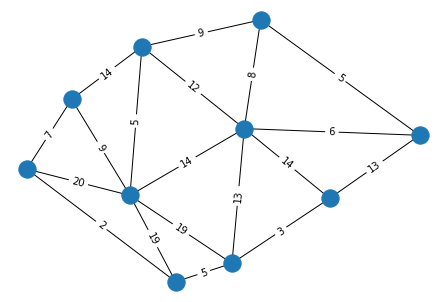

In [15]:
Hpts = gen_in_disk(10)
H = delaunay_graph(Hpts)
for u,v in H.edges:
    H[u][v]['weight'] = random.randint(1,20)

nx.draw(H, Hpts)
#_ = nx.draw_networkx_labels(H, Hpts, font_color="white")
_ = nx.draw_networkx_edge_labels(H, Hpts, edge_labels = nx.get_edge_attributes(H, 'weight'))

**Attention** : pour que la notion même de plus court chemin existe, dans un graphe non orienté, il est nécessaire que les coûts des arcs soient tous positifs. Sinon, en faisant des allers-retours entre deux sommets reliés par un arc de coût négatif, on peut diminuer infiniment le coût d'un chemin. Dans le cas d'un graphe orienté, il faut qu'il n'y ait pas de *cycles* de coût total négatif. Notez également que dans ce dernier cas, l'algorithme de Dijkstra n'est pas forcément le plus adapté, car sa complexité peut dégénrer dans le pire cas. On peut alors lui préférer l'algorithme de Bellman-Ford qui sera meilleur dans le pire cas, qui a en particulier l'avantage de ne pas partir en boucle infinie en cas de cycle négatif et permet de les détecter.

L'algorithme de Dijkstra utilise une file a priorité. Le principe d'une telle file est qu'on y insère des éléments avec une priorité. La file a priorité permet ensuite facilement :
* d'insérer de nouveaux éléments munis d'une priorité
* de déterminer l'élément actuellement de plus forte priorité
* de retirer cet élément

Pour l'algorithme de Dijkstra le principe est de calculer et mettre à jour en permanence la distance des sommets par rapport au sommet de départ. Cette distance déterminer la priorité d'un sommet. Plus cette distance est faible, plus le noeud est traité rapidement. Un code naïf est fourni ci-dessous pour gérer une file a priorité, mais ce code est mauvais en terme de complexité car chaque insertion parcourt linéairement tous les éléments de la file. Il serait possible de faire mieux avec des structures vues cette année, comme un arbre binaire de recherche, une skip-list ou un tas par exemple. Dans la librairie standard du c++, il existe un conteneur `priority_queue` qui utilise un tas binaire.

In [16]:
class pqueue(animated_container):
    def __init__(self,G):
        super().__init__(G)
        
        self.data = []    
        self.graph = G        
            
    #insertion non efficace
    def _insert_sort(self, d, v):
        self.data.append(None)
        i = len(self.data) - 2
        while i >=0 and self.data[i][0] < d:
            self.data[i+1] = self.data[i]
            i = i-1
        self.data[i+1] = (d,v)
                
    def push(self,v,d,u = None):
        p = self.graph.nodes[v]['parent']
        if p is not None:
            self.widths[self.graph[p][v]['index']] = self.init_width
        self._insert_sort(d, v)
        super().push(v,u)

        
    def pop(self):
        u = self.top()
        super().pop(u)
        self.data.pop()
        
    def top(self):
        t = self.data[-1]
        super().top(t[1])
        return t[1]
    
    def empty(self):
        super().empty()
        return len(self.data) == 0

Le déroulé de l'algorithme de Dijkstra est souvent représenté par une table. Le code ci-dessous permet une générer de telle table. Chaque ligne de la table représente une itération de l'algorithme, et donne pour chaque sommet du graphe la distance actuellement connue depuis le sommet de départ, ainsi que le prédécesseur du noeud sur le chemin depuis le sommet de départ réalisant cette distance. Par exemple si le sommet de départ est le sommet 0 et si pour le sommet 3 on a une distance 5 via un chemin 0 → 5 → 8 → 3 alors dans la colonne du sommet 3 de la table, on aura 5 comme distance et 8 comme prédécesseur. Dans le code ci-dessous, on verra dans chaque case de la table un couple (distance, prédécesseur).

In [17]:
from IPython.display import display, Markdown


class DijkstraTable:
    
    def __init__(self,G):
        self.G = G
        self.str = "|" + "|".join(["%d" % i for i in range(len(G.nodes))]) + "|\n"
        self.str = self.str + "|" + "|".join(["---" for n in G.nodes]) + "|\n"
        

    def step(self, active_node):
        line = ["" for n in G.nodes]
        for n in self.G.nodes:
            d = self.G.nodes[n]['distance']
            p = self.G.nodes[n]['parent']
            if d is None:
                line[n] = "X,X"
            else:
                if n == active_node:
                    line[n] = "**%d,%d**" % (d,p)
                else:
                    line[n] = "%d,%d" % (d,p)
        self.str = self.str + "|" + "|".join(line) + "|\n"
    
    def show(self):
        display(Markdown(self.str))

L'algorithme en lui-même reprend la structure d'un parcours en largeur. Notez ici que les sommets sont systématiquement ajoutés à la file à priorité dès qu'on a une distance plus courte que la distance connue, ce qui fait qu'on aura potentiellement plusieurs fois le même sommet dans la file. Ce n'est pas un problème, car **Dijkstra de fait jamais augmenter la distance à un sommet**. Du coup, si la distance d'un sommet change, c'est qu'elle devient plus petite, et donc que la nouvelle version insérée du sommet sortira de la file avant la version plus ancienne qui a une distance plus grande. Si la structure de file le permet, il est plus judicieux de modifier la priorité de l'élément présent dedans. Un tas binaire ne permet pas efficacement de modifier les priorités. Un arbre binaire de recherche ou une skip-list en seraient capables. Il existe également les *pairing heaps* ou les *fibonacci heaps* qui permettent de réaliser cette opération efficacement.

In [18]:
def dijkstra(G, start, s):    

    for n in G.nodes:
        G.nodes[n]['distance'] = None
        G.nodes[n]['parent'] = None
        
    table = DijkstraTable(G)
    
    s.push(start, 0)
    G.nodes[start]['distance'] = 0
    G.nodes[start]['parent'] = start
    
    while not s.empty():
        u = s.top()
        s.pop()
        table.step(u)
        du = G.nodes[u]['distance']
        for v in G.neighbors(u):
            dv = G.nodes[v]['distance']
            duv = du + G[u][v]['weight']
            if dv is None or duv < dv:
                G.nodes[v]['distance'] = duv
                G.nodes[v]['parent'] = u
                s.push(v, duv, u) #normalement ici si le noeud est déjà dans la file on le modifie

    return table

In [19]:
pq = pqueue(H)
table = dijkstra(H, 0, pq)
table.show()

|0|1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|
|**0,0**|X,X|X,X|X,X|X,X|X,X|X,X|X,X|X,X|X,X|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|X,X|X,X|X,X|**5,0**|X,X|X,X|13,0|X,X|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|**6,0**|X,X|X,X|X,X|5,0|X,X|X,X|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|20,1|X,X|X,X|5,0|19,1|X,X|**13,0**|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|20,1|X,X|X,X|5,0|16,8|X,X|13,0|**14,5**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|X,X|28,9|5,0|**16,8**|X,X|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|**19,9**|X,X|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|39,2|28,9|5,0|**16,8**|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|**19,9**|39,2|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|39,2|28,9|5,0|16,8|**21,6**|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|**23,7**|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|23,7|**28,9**|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|**23,7**|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


Cette table montre les itérations de l'algorithme sur le graphe précédent. 

Pour illustrer graphiquement ce parcours, nous allons assigner à chaque sommet des altitudes pour faire des montagnes

In [20]:
def mountains(x, y):
    def g(cx, cy, x, y):
        xd = x - cx
        yd = y - cy
        return np.exp(-(xd*xd + yd*yd) / 0.2)
                      
    return 100 * (g(0.5,0.5,x,y) + g(-0.5, -0.2, x, y) + g(-0.2, 0.6, x, y) + g(0.5, -0.4, x, y))

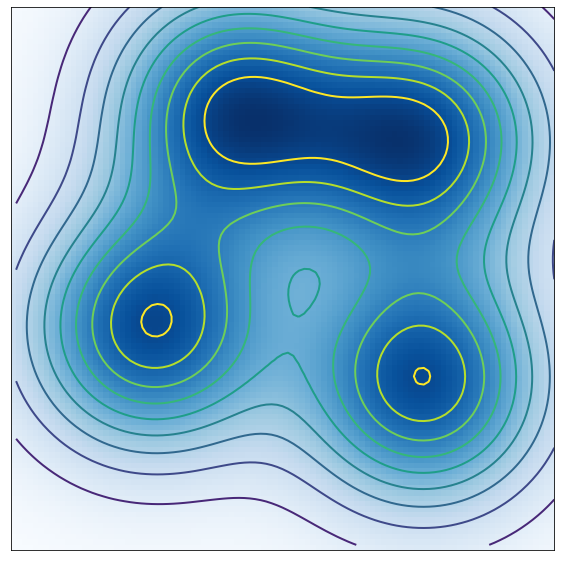

In [21]:
import numpy as np

x = np.arange(-1.0,1.0,0.02)
y = np.arange(-1.0,1.0,0.02)
X,Y = np.meshgrid(x, y)
Z = mountains(X, Y)

min_val = np.min(Z)
max_val = np.max(Z)
spacing = (max_val - min_val) / 10

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
im = plt.imshow(Z,cmap=plt.cm.Blues, origin='lower')
cset = plt.contour(Z,np.arange(min_val, max_val, spacing),linewidths=2, origin='lower')
plt.show()

ensuite, pour calculer la distance entre deux noeuds, nous utiliserons la distance euclidienne entre les positions des deux sommets du graphe, altitude comprise. Du coup le dénivelé est pris en compte, et plus la différence d'altitude entre deux sommets est importante, plus il sera coûteux d'emprunter l'arête qui les relie. ENd essous, la couleur des sommets est d'autant plus sombre que le noeud a une altitude élevée, et une arête est d'autant plus sombre que son poids est important.

In [22]:
def distance(p0, p1):
    d = 0
    for (c0,c1) in zip(p0, p1):
        d += (c0 - c1)*(c0 - c1)
    return math.sqrt(d)

for u,v in G.edges:
    p0 = pts[u]
    p1 = pts[v]
    h0 = mountains(*p0)
    h1 = mountains(*p1)
    G[u][v]['weight'] = distance([*p0, h0], [*p1, h1])

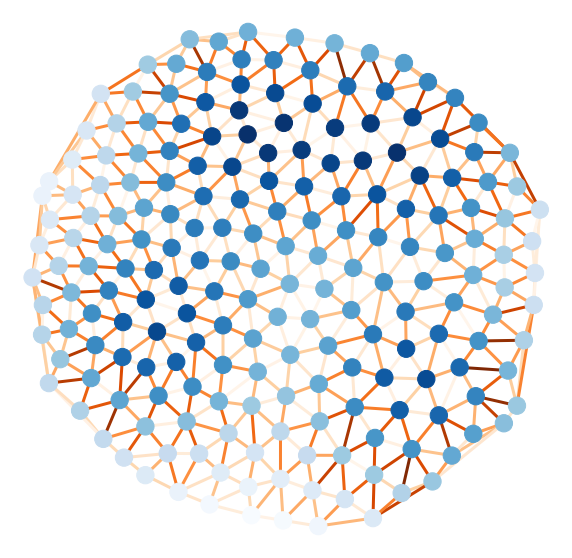

In [23]:
fig = plt.subplots(figsize=(10,10))
ec = [G[u][v]['weight'] for u,v in G.edges]
nc = [mountains(*pts[n]) for n in G.nodes]
nx.draw(G, pos=pts, edge_color=ec, node_color=nc, cmap=plt.cm.Blues, edge_cmap=plt.cm.Oranges, width=3)

In [24]:
pq = pqueue(G)
table = dijkstra(G, begin, pq)
# table.show() # la table est trop grosse pour être lisible

In [25]:
animate_graph(G, pts, pq.animation)

## Algorithme A*

L'algorithme de Dijkstra cherche les plus courts chemins d'un sommet du graphe vers tous les autres. Souvent, vous ne cherchez pas le chemin vers tous les autres sommets du graphe, mais simplement vers un sommet en particuler. Dans ce cas, Dijkstra vous donnera le bon résultat, mais fera plus de travail que nécessaire. Dans le cas où vous ne cherchez le plus court chemin que vers un sommet particulier, une première option consiste à interrompre l'algorithme de Dijkstra au moment où le sommet d'arrivée est traité, c'est à dire quand il sort de la file. L'algorithme A* permet éventuellement de faire mieux. 

Pour pouvoir le mettre en œuvre, il est nécessaire d'avoir une fonction qui étant donné deux sommets quelconques du graphe, renvoie une approximation de la distance pour aller de l'un à l'autre. De plus, pour garantir que le résultat de A* est correct, il est nécessaire que cette approximation soit toujours plus faible que la vraie distance. Dans notre exemple de graphe montagneux, on peut facilement définir une telle approximation en utilisant la distance à vol d'oiseau : la ligne droite sera toujours plus courte que le chemin passant par les sommets du graphe, et qui a de grande chance de faire quelques zig-zags.

In [26]:
def approx(G, pts, v, end):
    p0 = pts[v]
    p1 = pts[end]
    h0 = mountains(*p0)
    h1 = mountains(*p1)
    return distance([*p0, h0], [*p1, h1])

L'algorithme A* est ensuite une toute petite variation de l'algorithme de Dijkstra, qui consiste à utiliser l'approximation du chemin qu'il reste à parcourir pour définir la priorité des sommets dans la file à priorités. Au lieu d'utiliser comme priorité la longueur du plus court chemin actuellement connu depuis l'origine, on y ajoute l'approximation de la distance qu'il reste à parcourir.

In [27]:
def astar(G, pts, start, end, s):    

    for n in G.nodes:
        G.nodes[n]['distance'] = None
        G.nodes[n]['parent'] = None
    
    s.push(start, 0)
    G.nodes[start]['distance'] = 0
    G.nodes[start]['parent'] = start
    
    while not s.empty():
        u = s.top()
        s.pop()
        if u == end:
            return
        du = G.nodes[u]['distance']
        for v in G.neighbors(u):
            dv = G.nodes[v]['distance']
            duv = du + G[u][v]['weight']
            apx = duv + approx(G, pts, v, end) # ici on calcule l'approximation
            if dv is None or duv < dv:
                G.nodes[v]['distance'] = duv
                G.nodes[v]['parent'] = u
                s.push(v, apx, u) # ici on utilise l'approximation au lieu de la vraie distance

Dans cet exemple, le sommet d'arrivée est choisi comme celui le plus à droite.

In [28]:
end = rightmost(G, pts)
pq = pqueue(G)
astar(G, pts, begin, end, pq)

In [29]:
animate_graph(G, pts, pq.animation)

Notez que dans le cas où les poids des graphes sont positifs (ce qui est en général nécessaire pour utiliser Dijkstra), une approximation triviale consiste à renvoyer toujours zéro. Dans ce cas, si vous examinez l'algorithme A*, vous remarquerez que dans la mesure où toutes les approximations sont 0, on retombe sur l'algorithme de Dijkstra stoppé au moment où le sommet d'arrvée est traité. 

In [30]:
def zero(G, pts, v, end):
    return 0

approx_backup = approx
approx = zero
pq = pqueue(G)
astar(G, pts, begin, end, pq)

In [31]:
animate_graph(G, pts, pq.animation)

On voit ici que cette version visite plus de sommets avant de renvoyer le plus court chemin.

In [32]:
# Run me to hide code cells

from IPython.core.display import display, HTML
display(
    HTML(
        r"""
            <style id=hide>
                .collapsed .input_area {
                    overflow: hidden;
                    height: 1.7em;
                }
            </style>
            <script>
                var prompts = document.querySelectorAll(".prompt_container");
                for(prompt of prompts) {
                    prompt.onclick = (e) => {
                        e.target.closest(".input").classList.toggle("collapsed")
                    }
                }
            </script>
        """
    )
)